## 1. Introduction

This notebook implements Part 2: Analysis and Modeling of the DAT204M HW2 project.

It connects directly to the Supabase cloud database created in Part 1, retrieves data, and performs:

- Exploratory Data Analysis (EDA)
- Data visualization
- Simple Machine Learning modeling (Track A)

In this updated version, The objective is to build a predictive model that jointly predicts:

- CO₂ emissions per capita (tCO₂e, excl. LULUCF), and  
- GDP (current USD)

using energy, demographic, and renewable energy indicators.

This workflow highlights the end-to-end integration of cloud data persistence and data-driven analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from supabase import create_client

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY") or os.getenv("SUPABASE_ANON_KEY")
assert SUPABASE_URL and SUPABASE_KEY, "Missing SUPABASE_URL or Supabase key in .env"

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✅ Supabase client ready")


✅ Supabase client ready


In [2]:
TABLE_NAME = "brn_indicators"

# Multi-output targets for the new neural network
TARGETS = [
    "co2_per_capita_tco2e_excl_lulucf",
    "gdp_current_usd",
]

# 4 input features (no longer using GDP as a feature)
FEATURES = [
    "energy_use_kg_oe_per_capita",
    "population_total",
    "urban_pop_pct",
    "renewable_energy_consumption_pct",
]

# Optional filters if you want a specific country or year range
FILTER_COUNTRY = None  # e.g., "BRN" or None for all available
YEAR_MIN, YEAR_MAX = None, None  # e.g., 1990, 2022 or None


The four chosen input features represent interpretable drivers of emissions and economic activity:
 - `energy_use_kg_oe_per_capita` — captures energy intensity on a per-person basis.
 - `population_total` — reflects country scale and demographic size.
 - `urban_pop_pct` — urbanization correlates with industrial activity, GDP, and energy demand.
 - `renewable_energy_consumption_pct` — higher renewable shares can lower CO₂ emissions for a given energy level.

These were selected because they are consistently available in the `brn_indicators` table and provide a simple, clean baseline set of predictors for a multi-output model.

## 2. Data Retrieval from Supabase

We query the same `brn_indicators` table uploaded in Part 1.

Instead of reading from a local CSV, this notebook retrieves data directly from Supabase using the REST API (`supabase-py` client).

This demonstrates:
- Cloud-based reproducibility.
- Separation between data storage and analysis environments.
- Ability to re-run analysis from any machine with credentials.

In [3]:
# Build the query
q = supabase.table(TABLE_NAME).select("*")

if FILTER_COUNTRY:
    q = q.eq("country", FILTER_COUNTRY)
if YEAR_MIN is not None:
    q = q.gte("year", YEAR_MIN)
if YEAR_MAX is not None:
    q = q.lte("year", YEAR_MAX)

resp = q.execute()
df = pd.DataFrame(resp.data)

print(df.shape)
df.sort_values(["country", "year"]).head()

(350, 11)


,country,year,co2_per_capita_tco2e_excl_lulucf,co2_total_mtco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,renewable_electricity_pct,renewable_energy_consumption_pct,urban_pop_pct,missing_indicator_count
295,BRN,1990,16.843458,4.3000,6766.202658,6.039881e+09,255292,0.0,0.7,66.438,0
296,BRN,1991,18.696020,4.9095,7438.262038,6.284497e+09,262596,0.0,0.4,66.585,0
297,BRN,1992,19.868514,5.3613,7783.232736,6.327966e+09,269839,0.0,0.2,67.078,0
298,BRN,1993,19.535619,5.4108,7299.532663,6.203340e+09,276971,0.0,0.0,67.604,0
299,BRN,1994,19.338170,5.4938,6603.066579,6.467783e+09,284091,0.0,0.0,68.126,0


In [4]:
required_cols = ["country", "year"] + TARGETS + FEATURES
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing columns in table: {missing}"

# Ensure correct types
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

for col in FEATURES + TARGETS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep rows that have *all* targets
df = df.dropna(subset=TARGETS).copy()

display(df[["country", "year"] + TARGETS + FEATURES].head())
print(df[["country", "year"]].drop_duplicates().shape[0], "country-year rows")

,country,year,co2_per_capita_tco2e_excl_lulucf,gdp_current_usd,energy_use_kg_oe_per_capita,population_total,urban_pop_pct,renewable_energy_consumption_pct
0,BRN,2023,21.170326,1.509508e+10,9537.051561,458949,79.149,0.0
1,BRN,2024,21.170326,1.546313e+10,9537.051561,462721,79.439,0.0
2,IDN,1990,0.881620,1.061407e+11,461.478750,183501098,30.584,59.2
3,IDN,1991,0.935142,1.166220e+11,477.034665,186778238,31.613,58.4
4,IDN,1992,0.960602,1.280270e+11,489.759547,190043744,32.703,57.5


350 country-year rows


**Column Dictionary**

Key Variables Used in This Notebook
- `co2_per_capita_tco2e_excl_lulucf` — CO₂ emissions per person (tons), excluding LULUCF.
- `gdp_current_usd` — GDP measured in current US dollars.
- `energy_use_kg_oe_per_capita` — energy use per capita (kg of oil equivalent).
- `population_total` — total population of the country.
- `urban_pop_pct` — percent of population living in urban areas.
- `renewable_energy_consumption_pct` — proportion of energy consumption derived from renewable sources.

In [ ]:
num_cols = TARGETS + FEATURES
display(df[num_cols].describe().T)

missing_counts = df[num_cols].isna().sum().sort_values(ascending=False)
print("Missing values:\n", missing_counts)

,count,mean,std,min,25%,50%,75%,max
co2_per_capita_tco2e_excl_lulucf,350.0,4.545977e+00,5.901219e+00,5.861892e-02,6.164060e-01,1.796210e+00,7.090627e+00,2.362537e+01
gdp_current_usd,350.0,1.709432e+11,2.385773e+11,8.655599e+08,1.344133e+10,7.896367e+10,2.570312e+11,1.396300e+12
energy_use_kg_oe_per_capita,350.0,1.987937e+03,2.500569e+03,2.588368e+02,4.077525e+02,6.723931e+02,2.507310e+03,9.699300e+03
population_total,350.0,5.764443e+07,6.861710e+07,2.552920e+05,6.079419e+06,3.768746e+07,7.566818e+07,2.834879e+08
urban_pop_pct,350.0,4.787375e+01,2.464989e+01,1.543700e+01,2.836525e+01,4.452700e+01,6.659175e+01,1.000000e+02
renewable_energy_consumption_pct,350.0,3.618514e+01,2.963801e+01,0.000000e+00,4.425000e+00,3.210000e+01,6.025000e+01,9.110000e+01


Missing values:
 co2_per_capita_tco2e_excl_lulucf    0
gdp_current_usd                     0
energy_use_kg_oe_per_capita         0
population_total                    0
urban_pop_pct                       0
renewable_energy_consumption_pct    0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

EDA helps us understand relationships among key variables such as:
- CO₂ emissions per capita
- Energy consumption per capita
- GDP (current USD)
- Urban population percentage
- Renewable energy share

We use `pandas`, `matplotlib`, and `seaborn` to:
- Summarize basic statistics.
- Plot distributions and time series.
- Visualize correlations among features.

This step helps guide feature selection and verify data consistency.

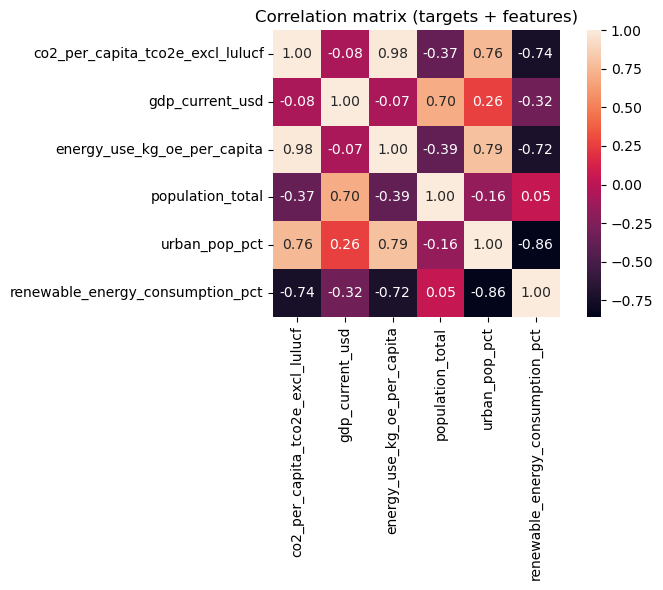

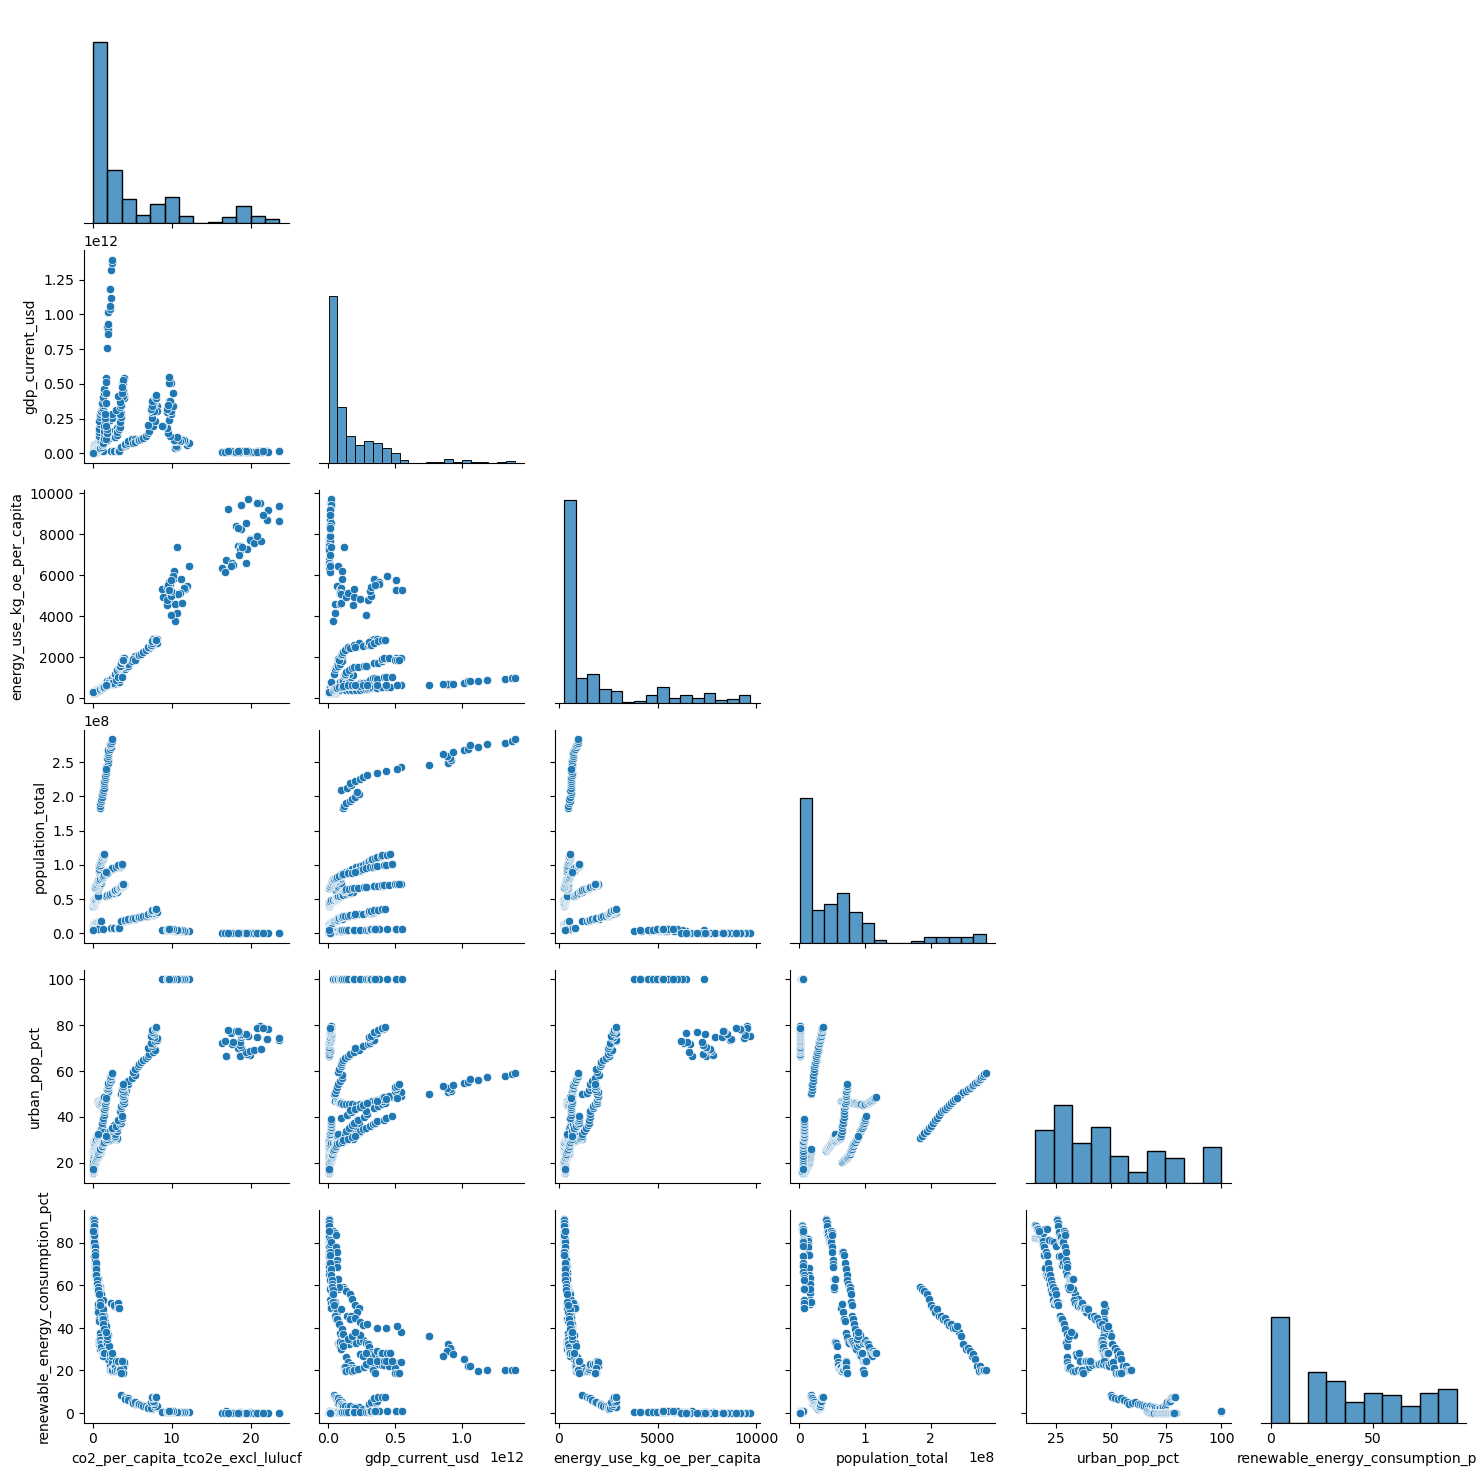

In [7]:
num_cols = TARGETS + [c for c in FEATURES if c in df.columns]

corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix (targets + features)")
plt.tight_layout()
plt.show()

# Pairplot can be slow on very large data; safe for your dataset sizes
sns.pairplot(df[num_cols].dropna(), corner=True, diag_kind="hist")
plt.show()

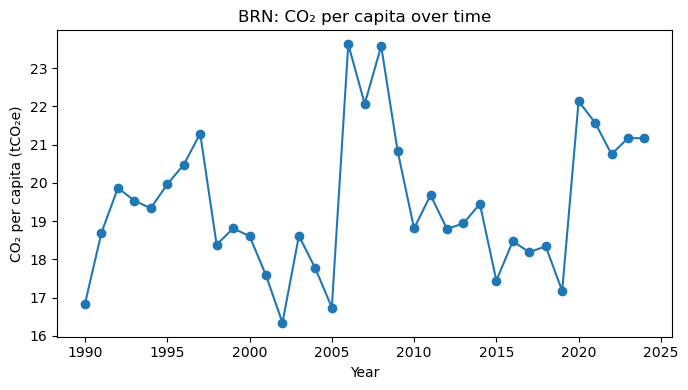

In [9]:
if "country" in df.columns:
    sample_country = FILTER_COUNTRY or df["country"].value_counts().index[0]
    ts = df[df["country"] == sample_country].sort_values("year")

    plt.figure(figsize=(7, 4))
    plt.plot(ts["year"], ts["co2_per_capita_tco2e_excl_lulucf"], marker="o")
    plt.title(f"{sample_country}: CO₂ per capita over time")
    plt.xlabel("Year")
    plt.ylabel("CO₂ per capita (tCO₂e)")
    plt.tight_layout()
    plt.show()

In [10]:
# Build modeling frame: country, year, targets + features
model_df = df[["country", "year"] + TARGETS + FEATURES].copy()

# Drop rows with missing features
model_df = model_df.dropna(subset=FEATURES).copy()
print(model_df.shape)
display(model_df.head())

(350, 8)


,country,year,co2_per_capita_tco2e_excl_lulucf,gdp_current_usd,energy_use_kg_oe_per_capita,population_total,urban_pop_pct,renewable_energy_consumption_pct
0,BRN,2023,21.170326,1.509508e+10,9537.051561,458949,79.149,0.0
1,BRN,2024,21.170326,1.546313e+10,9537.051561,462721,79.439,0.0
2,IDN,1990,0.881620,1.061407e+11,461.478750,183501098,30.584,59.2
3,IDN,1991,0.935142,1.166220e+11,477.034665,186778238,31.613,58.4
4,IDN,1992,0.960602,1.280270e+11,489.759547,190043744,32.703,57.5


In [11]:
X = model_df[FEATURES].values                      # shape: (n_samples, 4)
y = model_df[TARGETS].values                      # shape: (n_samples, 2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train size:", X_train_s.shape, "Test size:", X_test_s.shape)

Train size: (262, 4) Test size: (88, 4)


In [12]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=3000,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=30,
)

mlp.fit(X_train_s, y_train)

# Attach scaler like in train_model.py (optional, but nice for consistency)
mlp.scaler_ = scaler

In [13]:
# Predictions
y_tr_pred = mlp.predict(X_train_s)
y_te_pred = mlp.predict(X_test_s)

print("=== MODEL PERFORMANCE PER TARGET (MLPRegressor, multi-output) ===")
results = []

for i, name in enumerate(TARGETS):
    y_tr_true = y_train[:, i]
    y_te_true = y_test[:, i]
    y_tr_hat = y_tr_pred[:, i]
    y_te_hat = y_te_pred[:, i]

    r2_tr = r2_score(y_tr_true, y_tr_hat)
    r2_te = r2_score(y_te_true, y_te_hat)
    rmse_tr = root_mean_squared_error(y_tr_true, y_tr_hat)
    rmse_te = root_mean_squared_error(y_te_true, y_te_hat)

    # Baseline: predict mean of training target
    baseline_pred = np.full_like(y_te_true, np.mean(y_tr_true), dtype=float)
    r2_base = r2_score(y_te_true, baseline_pred)
    rmse_base = root_mean_squared_error(y_te_true, baseline_pred)

    print(f"\n--- {name} ---")
    print(f"R² train: {r2_tr:.3f} | R² test: {r2_te:.3f}")
    print(f"RMSE train: {rmse_tr:.3f} | RMSE test: {rmse_te:.3f}")
    print(f"Baseline R²: {r2_base:.3f} | Baseline RMSE: {rmse_base:.3f}")
    print(f"Neural Network improves R² by {(r2_te - r2_base):.3f}")

    results.append({
        "target": name,
        "r2_train": r2_tr,
        "r2_test": r2_te,
        "rmse_train": rmse_tr,
        "rmse_test": rmse_te,
        "r2_baseline": r2_base,
        "rmse_baseline": rmse_base,
    })

results_df = pd.DataFrame(results)
display(results_df)

=== MODEL PERFORMANCE PER TARGET (MLPRegressor, multi-output) ===

--- co2_per_capita_tco2e_excl_lulucf ---
R² train: 0.268 | R² test: 0.261
RMSE train: 5.083 | RMSE test: 4.894
Baseline R²: -0.027 | Baseline RMSE: 5.770
Neural Network improves R² by 0.288

--- gdp_current_usd ---
R² train: -0.558 | R² test: -0.401
RMSE train: 296639187532.978 | RMSE test: 282796204962.664
Baseline R²: -0.012 | Baseline RMSE: 240333335956.175
Neural Network improves R² by -0.389


,target,r2_train,r2_test,rmse_train,rmse_test,r2_baseline,rmse_baseline
0,co2_per_capita_tco2e_excl_lulucf,0.267593,0.26109,5.083379e+00,4.893617e+00,-0.02709,5.769503e+00
1,gdp_current_usd,-0.558054,-0.40124,2.966392e+11,2.827962e+11,-0.01203,2.403333e+11


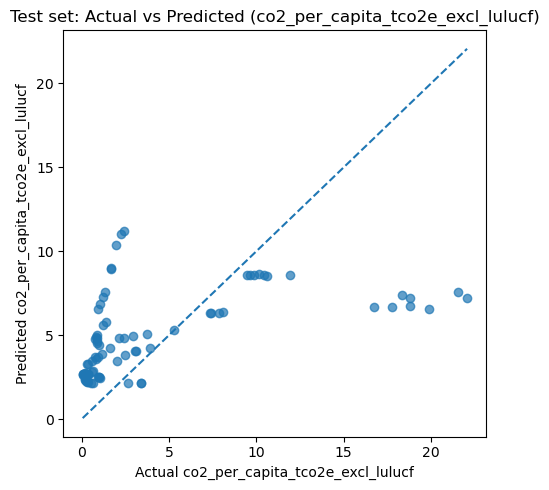

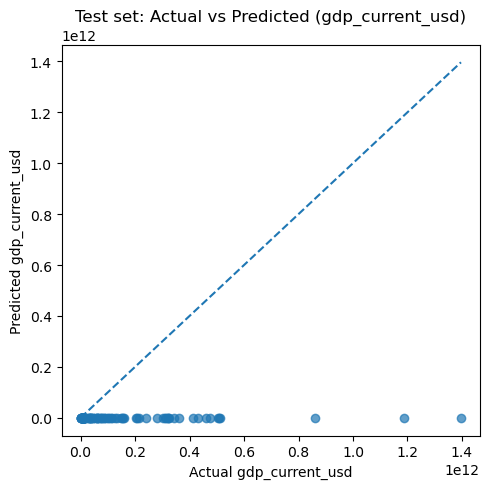

In [14]:
for i, name in enumerate(TARGETS):
    y_te_true = y_test[:, i]
    y_te_hat = y_te_pred[:, i]

    plt.figure(figsize=(5, 5))
    plt.scatter(y_te_true, y_te_hat, alpha=0.7)
    low = min(y_te_true.min(), y_te_hat.min())
    high = max(y_te_true.max(), y_te_hat.max())
    plt.plot([low, high], [low, high], linestyle="--")
    plt.xlabel(f"Actual {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"Test set: Actual vs Predicted ({name})")
    plt.tight_layout()
    plt.show()

Interpretation:
- CO₂ per capita: The predictions roughly align with the diagonal reference line, indicating moderate predictive ability.
- GDP: Predictions cluster near a flat line, confirming that the model fails to explain GDP variance from the available features.

In [17]:
# Baseline: predict the mean of each target column
baseline_pred = np.tile(y_train.mean(axis=0), (len(y_test), 1))

r2_base = r2_score(y_test, baseline_pred, multioutput='raw_values')
rmse_base = root_mean_squared_error(y_test, baseline_pred, multioutput='raw_values')

print("=== BASELINE (per-target mean predictor) ===")
for i, target in enumerate(TARGETS):
    print(f"{target}: R²={r2_base[i]:.3f} | RMSE={rmse_base[i]:.3f}")

=== BASELINE (per-target mean predictor) ===
co2_per_capita_tco2e_excl_lulucf: R²=-0.027 | RMSE=5.770
gdp_current_usd: R²=-0.012 | RMSE=240333335956.175


### 3.1 Summary

- Objective: Jointly predict CO₂ emissions per capita and GDP (current USD) using 4 features from the Supabase cloud database.
- Model: 4-layer `MLPRegressor` (ReLU + Adam), trained on standardized features.
- For CO₂ per capita, the neural network improves R² over the simple mean baseline.
- For GDP, the model performs worse than the mean baseline, suggesting that the four input features are not sufficient to explain variation in GDP in this dataset.

### 3.2 Notes and limitations

- Results depend on available rows after dropping missing targets and features.
- Neural networks can capture nonlinear patterns but are less interpretable than linear regression.
- Data is loaded directly from Supabase, not from a local CSV, which satisfies Part 2 requirements.
- TThe model fails to learn GDP patterns (negative R² on test set), likely due to the very large scale of GDP and insufficient explanatory power from the four selected features. Future improvements could include adding more economic indicators or predicting log(GDP) instead.

### 3.3 Next steps

- Compare against simpler baselines (separate linear models per target).
- Try tree-based models (RandomForestRegressor, GradientBoostingRegressor) for each target.
- Perform cross-validation and basic hyperparameter tuning (e.g., hidden sizes, learning rate).